In [1]:
from io import BytesIO
import plotly
import plotly.express as px
import plotly.graph_objects as go
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rc
import matplotlib
import base64
import time
import seaborn as sns
import os
from bs4 import BeautifulSoup
rc('font', family='AppleGothic') 		
plt.rcParams['axes.unicode_minus'] = False

os.getcwd()

'/Users/yangwoolee/git_repo/seoul_bike_dash/dashboard'

In [2]:
filtered_data = pd.read_parquet('/Users/yangwoolee/git_repo/data/220607_bike_record.parquet.gzip')
bike_info = pd.read_csv('/Users/yangwoolee/git_repo/data/static/options.csv', encoding='CP949')
near_sub = pd.read_csv("/Users/yangwoolee/git_repo/data/static/near_sub_station.csv", encoding="CP949")
station = pd.read_csv(
    "/Users/yangwoolee/git_repo/data/static/seoul_bike_station_01_12.csv", encoding="CP949")  

> ### 기본 함수 및 변수
raw_data(2022_06_15 수정)

In [9]:
def raw_data(query_data,val) : 
        quert_st_id1 = query_data[query_data['st_id1']==val]
        quert_st_id2 = query_data[query_data['st_id2']==val]
        filtered_data = pd.concat([quert_st_id1,quert_st_id2],axis=0).drop_duplicates()
        filtered_data.drop(columns='index',inplace=True)
        bm = (filtered_data['st_id1'] == val) & (filtered_data['st_id2'] == val)
        filtered_data = filtered_data[~bm]
        # filtered_data.reset_index(drop=True, inplace=True)

        # 대여
        filtered_data_start = filtered_data[(filtered_data['st_id1'] ==val) & (filtered_data['st_id2'] !=val)]

        # 반납
        filtered_data_end = filtered_data[(filtered_data['st_id2'] ==val) & (filtered_data['st_id1'] !=val)]
        
        return [filtered_data,filtered_data_end,filtered_data_start]


test_data = raw_data(filtered_data, 754)


def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2

    c = 2 * np.arcsin(np.sqrt(a))
    m = 6367 * c * 1000
    return m

> ### day_rent(22_06_15)

In [ ]:
def day_rent(filtered_data) :
    # 일별 자전거 대여
    filtered_data = filtered_data[0]
    filtered_data['weekday'] = filtered_data['date'].dt.weekday
    data = filtered_data.groupby('weekday').size()
    data_numpy = data.to_numpy()

    # max 요일
    max_value= np.where(data_numpy == data_numpy.max())[0][0]

    # 높이 normalize 후 0.5 더함( 0.5는 막대 길이를 의미함)
    height = list(map(lambda x : round(((x-data_numpy.min())/(data_numpy.max()-data_numpy.min()))+0.5,2), data_numpy ))

    # 사각형 정보
    bars = []
    for num, h in enumerate(height) :
        ist = [num,0,h,0.8] # x,y,h,w
        bars.append(ist)
    #날짜
    days = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
    # days = ["월","화","수","목","금","토","일"]

    # plot
    fig, ax = plt.subplots(figsize=(8,8))

    # bar = rect
    for num,(bar, days) in enumerate(zip(bars, days)) :
        x = bar[0]; y = bar[1]; h = bar[2];  w = bar[3]
        #max
        if num == max_value :
            color = '#35C768' # full color, font-color
        # 나머지
        else : 
            color = '#EBEEF2' # full color, font-color
        
        bbox = patches.FancyBboxPatch(
            (x,y),w,h,
            boxstyle="round,pad=-0.01,rounding_size=0.0",
            ec="none", fc=color,
            mutation_aspect= 0.5,
        )
        ax.add_patch(bbox)

        # 요일 넣기(padding고려해서 num으로 조정)
        if days == 'Fri' :
            plt.text(x+0.25, y-0.07, days, fontdict={'fontsize' : 14, 'color' :(0, 0, 0, 0.7)})
        else :    
            plt.text(x+0.15, y-0.07, days, fontdict={'fontsize' : 14, 'color' :(0, 0, 0, 0.7)})

        # 개수 넣기
        if data[num] > 10000 :
            plt.text(x+0.02,h+0.02, data[num], fontdict={'fontsize' : 14, 'color' :(0, 0, 0, 0.7)})

        elif 10000> data[num] > 1000 :
            plt.text(x+0.07,h+0.02, data[num], fontdict={'fontsize' : 14, 'color' :(0, 0, 0, 0.7)})
            
        else :
            plt.text(x+0.2,h+0.02, data[num], fontdict={'fontsize' : 14, 'color' :(0, 0, 0, 0.7)})

    plt.xlim(-0.2,7) # 넓이가 0.8이라서 그럼
    plt.ylim(0,2)
    plt.axis('off')
    # plt.close()

    # return fig

day_rent(test_data)

> ### time_rent(22_06_15)

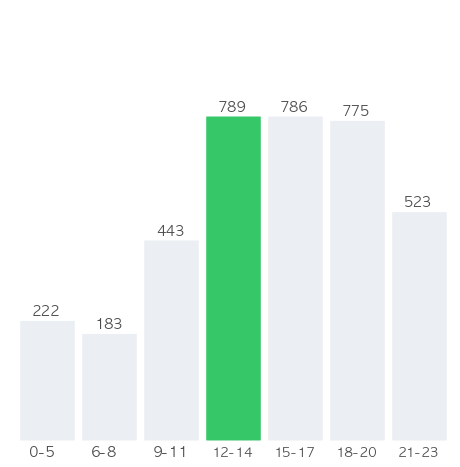

In [31]:
def time_rent(filtered_data) :
    # date 나눔
    time_data = test_data[0]['date']

    # 평일 주말 구분
    weekday = time_data.dt.weekday.isin([0,1,2,3,4])
    weekend = time_data.dt.weekday.isin([5,6])
    asd ='주말'

    a = time_data[weekend].dt.hour
    bins = [-1, 5, 8, 11, 14, 17, 20, 23]
    time=['0-5','6-8','9-11','12-14','15-17','18-20','21-23']
    data = a.groupby(pd.cut(a, bins=bins, labels=time)).size()
    data_numpy = data.to_numpy()

    # max 요일
    max_value= np.where(data_numpy == data_numpy.max())[0][0]

    # 높이 normalize 후 0.5 더함( 0.5는 막대 길이를 의미함)
    height = list(map(lambda x : round(((x-data_numpy.min())/(data_numpy.max()-data_numpy.min()))+0.5,2), data_numpy ))

    bars = []
    for num, h in enumerate(height) :
        ist = [num,0,h,0.9] # x,y,h,w
        bars.append(ist)

    # plot
    fig, ax = plt.subplots(figsize=(8,8))

    # bar = rect
    for num,(bar, time) in enumerate(zip(bars, time)) :
        x = bar[0]; y = bar[1]; h = bar[2];  w = bar[3]
        #max
        if num == max_value :
            color = '#35C768' # bg-color
        # 나머지
        else : 
            color = '#EBEEF2' # bg-color
        
        bbox = patches.FancyBboxPatch(
            (x,y),w,h,
            boxstyle="round,pad=-0.01,rounding_size=0.0",
            ec="none", fc=color,
            mutation_aspect= 0.5,
        )
        ax.add_patch(bbox)

        # 요일 넣기(padding고려해서 num으로 조정)
        if len(time) > 4 :
            plt.text(x+0.1, y-0.07, time, fontdict={'fontsize' : 13, 'color' :(0, 0, 0, 0.7)})
        else :    
            plt.text(x+0.15, y-0.07, time, fontdict={'fontsize' : 14, 'color' :(0, 0, 0, 0.7)})

        # 개수 넣기
        if data[num] > 10000 :
            plt.text(x+0.02,h+0.02, data[num], fontdict={'fontsize' : 14, 'color' :(0, 0, 0, 0.7)})

        elif 10000> data[num] > 1000 :
            plt.text(x+0.07,h+0.02, data[num], fontdict={'fontsize' : 14, 'color' :(0, 0, 0, 0.7)})
            
        else :
            plt.text(x+0.2,h+0.02, data[num], fontdict={'fontsize' : 14, 'color' :(0, 0, 0, 0.7)})

    plt.xlim(-0.2,7) # 넓이가 0.8이라서 그럼
    plt.ylim(0,2)
    plt.axis('off')
time_rent(test_data)

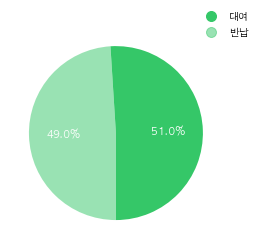

In [71]:
def total_rent(filtered_data) :
    # 데이터 정제
    a = len(filtered_data[1])
    b = len(filtered_data[2])
    percent = int(a / (a + b) * 100)

    ratio = [percent, 100-percent]
    colors = ['#35C768','#35c76880']
    plt.pie(ratio,startangle=270, autopct='%.1f%%',colors=colors, textprops=dict(color="w"))
    # plt.legend(['대여','반납'], bbox_to_anchor=(1,1), borderpad=0, framealpha=0) ## 범례 표시
    texts = ["대여", "반납"]
    patches = [plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=colors[i], 
            label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
    plt.legend(handles=patches, bbox_to_anchor=(1, 1), 
           loc='center', facecolor="white", framealpha=0 )
total_rent(test_data)

> ### recommend_sub_station(22_05_15)

In [ ]:
class recommend_sub_station:
    def __init__(self, filtered_data, stat_id, near_sub, station, bike_info, num=20):
        """

        해당 대여소에서 자주 이용하는 지하철역과 그 주변에 있는 따릉이 대여소를 추천하는 매서드임.
        filtered_data는 원하는 대여소가 sorting 된 DataFrame이 필요함.
        
        filter_start는 "대여소" 또는 "역"만 올 수 있음.

        """
        self.stat_id = stat_id
        self.near_sub = near_sub
        self.station = station
        self.filtered_data = filtered_data
        self.bike_info = bike_info

        print(self.bike_info.query('value == @self.stat_id').label)
        """
        개별 대여소별로 해당 대여소와 얼마나 교류가 있는지 확인한다.
        """

        # ex) 기준대여소 to 다른 대여소 (1to2)
        total_num_left = filtered_data[filtered_data["st_id1"] == stat_id][
            "st_id2"
        ].value_counts()

        # ex) 다른 대여소 to 기준대여소 (2to1)
        total_num_right = filtered_data[filtered_data["st_id2"] == stat_id][
            "st_id1"
        ].value_counts()

        # 1to2, 2to1 합치기
        combine_values = pd.concat([total_num_left, total_num_right], axis=1)
        combine_values.fillna((1), inplace=True)
        combine_values.rename(columns=dict(st_id2="1to2", st_id1="2to1"), inplace=True)

        # 계산 결과 종합
        result_concat = (
            combine_values.reset_index().groupby("index")[["1to2", "2to1"]].sum()
        )

        """
        역 주변 대여소로 특정할 경우 역과 관련된 따릉이 대여소는 제외하는 기능 추가
        """
        # 역 주변 대여소가 검색될 때 해당역 주변 대여소는 제거한다. | 316 대여소는 종각역과 관련됐는데, 종각과 관련된 대여소는 제거했다.
        try:
            filter_sub = near_sub.query("bi_st_id == @stat_id")["sub_name"].iloc[0]
            filter_sub_2 = near_sub.query("sub_name ==@filter_sub")["bi_st_id"].values
            result_concat = result_concat[~result_concat.index.isin(filter_sub_2)]
        except:
            pass

        """
        총 이동횟수를 구한 뒤 50회 미만인 대여소는 이동량이 없다고 판단.
        """

        # 이동기록 기록 50건 이하 제거
        count_rent = 50
        result_concat = result_concat[
            (result_concat["1to2"] > count_rent) | (result_concat["2to1"] > count_rent)
        ]

        ### 지하철만 모은건데 전체 대여소를 설정하는게 더 좋다고 생각해서 아래와 같이 변경하였음.
        # 지하철역 인근 따릉이 대여소 정보와 종합
        # sorted_sub = pd.merge(
        #     result_concat,
        #     near_sub,
        #     how="left",
        #     left_on=result_concat.index,
        #     right_on="bi_st_id",
        # ).dropna(subset=["sub_name"])
        # self.asd= sorted_sub.copy()

        sorted_sub = pd.merge(
            result_concat,
            near_sub,
            how="left",
            left_on=result_concat.index,
            right_on="bi_st_id",
        ).sort_values(by=['1to2'],ascending=False)
        # sorted_sub = pd.merge(
        #     result_concat,
        #     near_sub,
        #     how="left",
        #     left_on=result_concat.index,
        #     right_on="bi_st_id",
        # ).sort_values(by=['1to2'],ascending=False)[:50]

        """
        대여소를 기준으로 다른 대여소와 거리 계산 
        """
        # 기준 대여소와 역근처 대여소 직선 거리계산
        station_lat_lon = station[station["st_id"].isin(sorted_sub["bi_st_id"])][
            ["st_id", "st_name", "latitude", "longtitude"]
        ]

        dist_to_station = haversine_np(
            station.loc[station["st_id"] == stat_id, "longtitude"].values,
            station.loc[station["st_id"] == stat_id, "latitude"].values,
            station_lat_lon["longtitude"].values,
            station_lat_lon["latitude"].values,
        )
        station_lat_lon["distance"] = dist_to_station

        #  해당 대여소와의 거리정보 종합
        sorted_sub = pd.merge(
            sorted_sub, station_lat_lon, left_on="bi_st_id", right_on="st_id"
        ).drop(columns=["st_id"])

        """
        연산 속도를 줄이기 위해 top num개 대여소만 선정
        """
        sorted_sub["total"] = sorted_sub["1to2"] + sorted_sub["2to1"]
        sorted_sub = sorted_sub.sort_values(by="total", ascending=False)[
            :num
        ]  #####################
        self.test_val = sorted_sub

        """
        가는 시간 및 거리 계산
        """
        # 대여소별 예상 도착시간 계산
        result_station = []
        for j in sorted_sub['bi_st_id'] : 
            BM = (test_data[0]["st_id2"] == j)
            st_id1_time = (
                test_data[0][BM]["riding_time"]
                .value_counts()
                .sort_values(ascending=False)
            )
            BM = (test_data[0]["st_id1"] == j)
            st_id2_time = (
                test_data[0][BM]["riding_time"]
                .value_counts()
                .sort_values(ascending=False)
            )

            ### 1to2 걸린시간 + 2to1 걸린시간 합
            all_rent =  st_id1_time.add(st_id2_time, fill_value=0)

            ### 1to2 & 2to1 대여기록 합
            total_record = all_rent.sum()

            k=[]
            i=2
            ### 기록 많은 순만 종합
            while len(k) < 1 :
                k = all_rent[all_rent>= (total_record/i)]
                i=i*1.5
                
            ### 대여시간 
            ind = k.index
            ### 대여기록
            val = k.values
            ### 대여기록 합
            a = k.sum()
            ### 대여시간 * 대여기록
            asddd = sum([ a*b for a,b in zip(ind,val)])
            # 평균 시간
            ddddd = asddd/a

            # 올림 
            result = round(ddddd,0)
            result_station.append(result)

        # 예상시간정보 종합(대여소: 대여소에서 출발)
        est_time = pd.DataFrame(result_station, columns=["대여소"])

        # return 자료 생성
        self.nearest_sub = pd.concat(
            [sorted_sub.reset_index(drop=True), est_time], axis=1
        )

        b= self.nearest_sub.sub_name.isna()

        var = np.where(b==True,'자주가는 대여소','자주가는 지하철역')

        self.nearest_sub['color']=var


    def table_info(self):

        # 대여소 예상시간 테이블 만들기
        nearest_sub_sorted = (
            self.nearest_sub[
                ["sub_name", '대여소']
            ]
        ).dropna(subset='sub_name').drop_duplicates(subset='sub_name')
        nearest_sub_sorted.columns = ["역이름", "예상시간"]

        nearest_sub_sorted["예상시간"] = nearest_sub_sorted["예상시간"].apply(
            lambda x: str(int(x)) + "분"
        )

        return nearest_sub_sorted

    def frequent_estimation(self ,num=30) : 
        data = (
        self.nearest_sub
        .query('color == "자주가는 대여소"')[:num]
        )
        data_index = data.bi_st_id.to_list()

        # labels = bike_info.query('value == @data_index')
        est_time = data[['st_name','대여소']]
        est_time.columns = ['대여소 이름', '예상시간']
        # result = pd.merge(labels, est_time, how='left', left_on='value',right_on='bi_st_id').sort_values(by='total',ascending=False)
        return est_time


    def plotly_image(self):

        # figure 만들기
        fig = px.scatter_mapbox(
            self.nearest_sub,
            lat="latitude",
            lon="longtitude",
            # hover_data={'latitude':False,'longtitude':False,'st_name':True},
            opacity=0.8,
            # size='total', size_max=20,
            zoom=13,
            custom_data=['st_name','대여소','total','distance'],
            color='color',
            color_discrete_sequence=["green", "brown"],
        )
        # marker 정보
        # fig.for_each_trace(lambda t: t.update(name="<b>" + t.name + "</b>"))
        fig.update_traces(marker={"size": 9},hovertemplate="대여소 : %{customdata[0]} <br>예상시간 : %{customdata[1]}분 <br>대여기록 : %{customdata[2]}건")

        # 해당 따릉이 대여소 색 표시
        fig_2 = go.Figure(
            go.Scattermapbox(
                lat=self.station.query("st_id==@self.stat_id")["latitude"],
                lon=self.station.query("st_id==@self.stat_id")["longtitude"],
                mode="markers",
                marker={"size": 20, "color": "black", "opacity": 0.3},
                showlegend=False
            )
        )
        fig_2.update_traces(hoverinfo='skip')
        fig.add_trace(fig_2.data[0])

        # 해당 따릉이 대여소 둘레 표시
        fig_3 = go.Figure(
            go.Scattermapbox(
                name="",
                lat=self.station.query("st_id==@self.stat_id")["latitude"],
                lon=self.station.query("st_id==@self.stat_id")["longtitude"],
                mode="markers",
                marker={"size": 9, "color": "red", "opacity": 0.9},
                text=self.bike_info.query("value==@self.stat_id")["label"].values,
                hovertemplate = "%{text}",
                showlegend=False
            )
        )
        # fig_3.update_traces(hoverinfo='skip',hovertemplate=None)
        fig.add_trace(fig_3.data[0])
        

        # 지도 정보 업데이트
        # fig.update_traces(hoverinfo='skip',hovertemplate=None)
        fig.update_layout(
            margin=dict(l=0, r=0, t=0, b=0),
                mapbox=dict(
                accesstoken="pk.eyJ1IjoieWFuZ29vcyIsImEiOiJjbDNqd2tkN2IwbGdmM2pvNzF0c2M4NnZkIn0.J3IjPYg3w28cGiWkUD7bnA",
                style='mapbox://styles/yangoos/cl4cljdka001o14n3cll7whrh/draft'
            ),
            legend=dict(
                yanchor="top",
                y=0.98,
                xanchor="right",
                x=0.98,
                bgcolor="rgba(223, 235, 223, 0.8)",
                title={'text': None}
            ),
        )
        fig.show()
        # off_plot = plotly.io.to_html(
        #     fig,
        #     config=dict(displayModeBar=False),
        #     include_plotlyjs=False,
        #     full_html=True,
        #     include_mathjax=False,
        # )
        # bs = BeautifulSoup(off_plot, features="html.parser")
        # div_data = bs.find("div", "plotly-graph-div")
        # script_data = bs.find("script").text.replace(" ", "")
        # context = {"div_data": str(div_data), "script_data": str(script_data)}
        # return context


sorted_sub = recommend_sub_station(test_data[0],754,near_sub, station, bike_info).test_val
# sorted_sub = recommend_sub_station(test_data[0],141,near_sub, station, bike_info).table_info()




In [23]:
sorted_sub.dropna(subset='sub_name').head(10)

,1to2,2to1,bi_st_id,sub_st_id,sub_name,sub_line,sub_long,sub_lat,st_name,latitude,longtitude,distance,total
0,3385.0,2681.0,744,4111,신목동,9호선,126.883080,37.544277,신목동역 2번 출구,37.543842,126.882545,597.711355,6066.0
5,440.0,719.0,766,4111,신목동,9호선,126.883080,37.544277,신목동역 3번출구,37.544260,126.883250,674.811933,1159.0
14,214.0,509.0,773,4110,염창,9호선,126.874916,37.546936,"염창역 3, 4번 출구 사이",37.546707,126.874573,645.625170,723.0
12,234.0,332.0,765,2522,오목교,5호선,126.875181,37.524496,오목교역 3번출구,37.524776,126.875481,1821.730026,566.0
17,149.0,124.0,770,2521,목동,5호선,126.864931,37.526065,목동역5번출구 교통정보센터 앞,37.525715,126.864868,2005.496748,273.0


In [277]:
def raw_data(query_data,val) : 
        quert_st_id1 = query_data[query_data['st_id1']==val]
        quert_st_id2 = query_data[query_data['st_id2']==val]
        filtered_data = pd.concat([quert_st_id1,quert_st_id2],axis=0).drop_duplicates()
        filtered_data.drop(columns='index',inplace=True)
        bm = (filtered_data['st_id1'] == val) & (filtered_data['st_id2'] == val)
        filtered_data = filtered_data[~bm]
        # filtered_data.reset_index(drop=True, inplace=True)

        # 대여
        filtered_data_start = filtered_data[(filtered_data['st_id1'] ==val) & (filtered_data['st_id2'] !=val)]

        # 반납
        filtered_data_end = filtered_data[(filtered_data['st_id2'] ==val) & (filtered_data['st_id1'] !=val)]
        
        return [filtered_data,filtered_data_end,filtered_data_start]


num = 141

test_data = raw_data(filtered_data, num)


sorted_sub = recommend_sub_station(test_data[0],num,near_sub, station, bike_info).test_val

for j in sorted_sub['bi_st_id'] : 
    BM = (test_data[0]["st_id2"] == j)
    st_id1_time = (
        test_data[0][BM]["riding_time"]
        .value_counts()
        .sort_values(ascending=False)
    )
    BM = (test_data[0]["st_id1"] == j)
    st_id2_time = (
        test_data[0][BM]["riding_time"]
        .value_counts()
        .sort_values(ascending=False)
    )

    ### 1to2 걸린시간 + 2to1 걸린시간 합
    # print(st_id1_time.sum(),st_id2_time.sum())
    all_rent =  st_id1_time.add(st_id2_time, fill_value=0)

    ### 1to2 & 2to1 대여기록 합
    total_record = all_rent.sum()

    k=[]
    i=2
    ### 기록 많은 순만 종합
    while len(k) < 1 :
        k = all_rent[all_rent>= (total_record/i)]
        i=i*1.5
    # print(len(k))
        
    ### 대여시간 
    ind = k.index
    ### 대여기록
    val = k.values
    ### 대여기록 합
    a = k.sum()
    # print('대여기록' ,a)
    ### 대여시간 * 대여기록
    asddd = sum([ a*b for a,b in zip(ind,val)])
    # print('대여시간' ,asddd)
    # 평균 시간
    ddddd = asddd/a

    # 올림 
    result = round(ddddd,0)
    print(j,result)


36    141 : 연대 대운동장 옆
Name: label, dtype: object
128 5.0
3116 5.0
134 5.0
3119 3.0
135 5.0
116 6.0
138 3.0
3010 8.0
421 20.0
196 5.0
137 8.0
498 8.0
191 16.0
125 9.0
114 10.0
162 8.0
3107 6.0
130 7.0
115 7.0
167 16.0


In [191]:
a = pd.Series({'a':1,'b':2,'c':3,'f':4})
b = pd.Series({'a':1,'b':2,'d':3,'f':4})
a.add(b, fill_value=0)

a    2.0
b    4.0
c    3.0
d    3.0
f    8.0
dtype: float64

In [278]:
bike_info[bike_info.label.str.contains('서강대 남문')]

,Unnamed: 0,value,label
22,22,125,125 : 서강대 남문 옆


In [242]:
num = 565

test_data = raw_data(filtered_data, num)
recommend_sub_station(test_data[0],num,near_sub, station, bike_info).plotly_image()

393    565 : 옥수역 3번출구
Name: label, dtype: object


In [308]:
data = (
    test_data[0]
    .groupby(f"st_id1")
    .size()
    .sort_values(ascending=False)[1:4]
)
data_index = data.index.to_list()

labels = bike_info.query('value == @data_index')['label'].to_list()
labels



['744 : 신목동역 2번 출구', '755 : 목동1단지아파트 상가 앞 (월촌중학교 버스정류소 옆)', '766 : 신목동역 3번출구']

> ### subwaystation table info

In [207]:
def recommend_sub_station(filtered_data, filter_start='대여소') :
    # ex) 기준대여소 to 다른 대여소 (1to2)
    total_num_left = filtered_data[filtered_data["st_id1"] == stat_id]["st_id2"].value_counts()  # 기준 대여소에서 빌리면 주로 향하는 목적지는?

    # ex) 다른 대여소 to 기준대여소 (2to1)
    total_num_right = filtered_data[filtered_data["st_id2"] == stat_id]["st_id1"].value_counts()  # 어떤 대여소에서 기준 대여소로 이동할까?

        # 1to2, 2to1 합치기
    combine_values = pd.concat([total_num_left, total_num_right], axis=1)
    combine_values.fillna((1), inplace=True)
    combine_values.rename(columns=dict(st_id2="1to2", st_id1="2to1"), inplace=True)

    # 계산 결과 종합
    result_concat = (
        combine_values.reset_index().groupby("index")[["1to2", "2to1"]].sum()
    )

    # 역 주변 대여소가 검색될경우 해당 대여소는 제거하기 | 316 대여소는 종각역과 관련됐는데, 종각과 관련된 대여소는 제거했다.
    try:
        filter_sub = near_sub.query("bi_st_id == @stat_id")["sub_name"].iloc[0]
        filter_sub_2 = near_sub.query("sub_name ==@filter_sub")["bi_st_id"].values
        result_concat = result_concat[~result_concat.index.isin(filter_sub_2)]
    except:
        pass


    # 대여소 별 총 이동 횟수
    result_concat["total"] = abs(
        (result_concat["1to2"] + result_concat["2to1"])
    ) 

    # 지하철역 인근 따릉이 대여소 정보와 종합
    sub_bike = pd.merge(
        result_concat,
        near_sub,
        how="left",
        left_on=result_concat.index,
        right_on="bi_st_id",
    )

    # 지하철역 없는 따릉이 제거 
    sorted_sub = sub_bike.dropna(subset=["sub_st_id"]).sort_values(
        by="total", ascending=False
    ).dropna(subset=['sub_name'])

    # 기록 50건 이하 제거
    count_rent = 50
    sorted_sub = sorted_sub[(sorted_sub['1to2'] > count_rent) | (sorted_sub['2to1'] > count_rent) ]

    # 기준 대여소와 역근처 대여소 직선 거리계산
    station_lat_lon = station[station["st_id"].isin(sorted_sub["bi_st_id"])][
        ["st_id", "st_name", "latitude", "longtitude"]
    ]
    return station_lat_lon
    dist_to_station = haversine_np(
        station.loc[station["st_id"] == stat_id, "longtitude"].values,
        station.loc[station["st_id"] == stat_id, "latitude"].values,
        station_lat_lon["longtitude"].values,
        station_lat_lon["latitude"].values,
    )
    station_lat_lon["distance"] = dist_to_station

    #  해당 대여소와의 거리정보 종합
    sorted_sub = pd.merge(
        sorted_sub, station_lat_lon, left_on="bi_st_id", right_on="st_id"
    ).drop(columns=["st_id"])

    # 대여소별 예상 도착시간 계산
    result_station = []
    for station_id in sorted_sub["bi_st_id"]:

        # 대여소 기준 해당 역으로 가는 시간
        BM = filtered_data["st_id2"] == station_id
        st_id1_time = (
            filtered_data[BM]["riding_time"]
            .value_counts()
            .sort_values(ascending=False)
        )
        mean_id1 = round(st_id1_time.index[:3].values.mean(), 1)

        # 해당 역에서 대여소로 가는 시간
        BM = filtered_data["st_id1"] == station_id
        st_id2_time = (
            filtered_data[BM]["riding_time"]
            .value_counts()
            .sort_values(ascending=False)
        )
        mean_id2 = round(st_id2_time.index[:3].values.mean(), 1)

        # st_id1_time.plot.bar()
        result_station.append([mean_id1, mean_id2])


    # 예상시간정보 종합(대여소: 대여소에서 출발)
    est_time = pd.DataFrame(result_station, columns=["대여소", "역"])


    # return 자료 생성
    nearest_sub = pd.concat([sorted_sub.reset_index(drop=True), est_time], axis=1)
    
    if filter_start == "대여소":
        sub_sorted_station = (
            nearest_sub.groupby("sub_name")["1to2"]
            .sum()
            .sort_values(ascending=False)
            .reset_index(drop=False)
        )  # 대여소 별 이동량 종합
        counts = "1to2"

    elif filter_start == "역":
        sub_sorted_station = (
            nearest_sub.groupby("sub_name")["2to1"]
            .sum()
            .sort_values(ascending=False)
            .reset_index(drop=False)
        )
        counts = "2to1"

    # 역 이름 추출
    name_sub = sub_sorted_station["sub_name"].tolist()

    # 대여소 예상시간 테이블 만들기
    nearest_sub_sorted = (
        nearest_sub[["bi_st_id","sub_name", counts, f"{filter_start}"]]
        .sort_values(by=f"{filter_start}")
        .query("sub_name == @name_sub")
        .reset_index(drop=True)
    )
    nearest_sub_sorted.columns = ["대여소 번호", "역사명", "대여기록", "예상시간"]
    # nearest_sub_sorted = nearest_sub_sorted.query("대여기록 > 50").copy()

    nearest_sub_sorted["예상시간"] = nearest_sub_sorted["예상시간"].apply(
        lambda x: str(int(x)) + "분"
    )
    nearest_sub_sorted["대여기록"] = nearest_sub_sorted["대여기록"].apply(
        lambda x: str(int(x)) + "건"
    )

    return nearest_sub_sorted

recommend_sub_station(filtered_data, filter_start='대여소')

In [22]:
def raw_data(query_data , val : int) : 
    # BM = (df['st_id1'] == val) | (df['st_id2'] == val )
    # filtered_data = df[BM]

    # 대여
    filtered_data_start = query_data[(query_data['st_id1'] ==val) & (query_data['st_id2'] !=val)]

    # 반납
    filtered_data_end = query_data[(query_data['st_id2'] ==val) & (query_data['st_id1'] !=val)]
    
    return [query_data,filtered_data_end,filtered_data_start]

> ### 일별 자전거 대여

ax.patches => 개별 bar 정보(x,y,h,w)를 확인할 수 있음.

ax.patches[0].patch.get_bbox() 확인한 정보를 변수로 불러올 수 있음
> https://stackoverflow.com/questions/61568935/seaborn-barplot-with-rounded-corners

print(p.properties()) <= 정보를 불러오는 기능인듯 

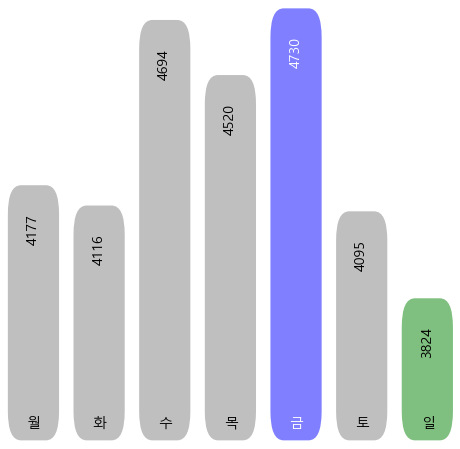

In [39]:
def day_rent(filtered_data :list) :
    # 일별 자전거 대여
    data = filtered_data[0].groupby('weekday').size()

    data_numpy = data.to_numpy()

    # max 요일
    max_value= np.where(data_numpy == data_numpy.max())[0][0]
    max_value

    # min 요일
    min_value= np.where(data_numpy == data_numpy.min())[0][0]
    min_value

    # 높이 normalize 후 0.5 더함( 0.5는 막대 길이를 의미함)
    height = list(map(lambda x : round(((x-data_numpy.min())/(data_numpy.max()-data_numpy.min()))+0.5,2), data_numpy ))

    # 사각형 정보
    bars = []
    for num, h in enumerate(height) :
        ist = [num,0,h,0.8] # x,y,h,w
        bars.append(ist)
    #날짜
    days = ["월","화","수","목","금","토","일"]

    # plot
    fig, ax = plt.subplots(figsize=(8,8))

    # bar = rect
    for num,(bar, days) in enumerate(zip(bars, days)) :
        x = bar[0]; y = bar[1]; h = bar[2];  w = bar[3]
        #max
        if num == max_value :
            color = ['blue','white'] # full color, font-color
        #min
        elif num == min_value : 
            color = ['green','black'] # full color, font-color
        # 나머지
        else : 
            color = ['gray','black'] # full color, font-color
        
        bbox = patches.FancyBboxPatch(
            (x,y),w,h,
            boxstyle="round,pad=-0.01,rounding_size=0.2",
            ec="none", fc=color[0],
            mutation_aspect= 0.5,
            alpha=0.5
        )
        ax.add_patch(bbox)

        # 요일 넣기(padding고려해서 num으로 조정)
        plt.text(x+0.3,y+0.05, days, fontdict={'fontsize' : 14, 'color' : color[1]})

        # 개수 넣기
        plt.text(x+0.3,h-0.2, data[num],rotation=90, fontdict={'fontsize' : 14, 'color' : color[1]})


    plt.xlim(0,6.8) # 넓이가 0.8이라서 그럼
    plt.ylim(0,1.5)
    plt.axis('off')
    # plt.close()


day_rent(raw_data)

> ### 시간대별 이용 비교

In [88]:
BM = (df['st_id1'] == val) | (df['st_id2'] == val )
query_data = df[BM]

In [ ]:
query_data['time'] =  '2021-01-01 ' + query_data['date'].dt.time.apply(str)
query_data

# query_data[']
test_count = query_data.groupby([pd.Grouper(key='time',freq='H')]).size()
test_count

In [ ]:
def day_rent(filtered_data :list) :
    # 일별 자전거 대여
    data = filtered_data[0].groupby('weekday').size()

    data_numpy = data.to_numpy()

    # max 요일
    max_value= np.where(data_numpy == data_numpy.max())[0][0]
    max_value

    # min 요일
    min_value= np.where(data_numpy == data_numpy.min())[0][0]
    min_value

    # 높이 normalize 후 0.5 더함( 0.5는 막대 길이를 의미함)
    height = list(map(lambda x : round(((x-data_numpy.min())/(data_numpy.max()-data_numpy.min()))+0.5,2), data_numpy ))

    # 사각형 정보
    bars = []
    for num, h in enumerate(height) :
        ist = [num,0,h,0.8] # x,y,h,w
        bars.append(ist)
    #날짜
    days = ["월","화","수","목","금","토","일"]

    # plot
    fig, ax = plt.subplots(figsize=(8,8))

    # bar = rect
    for num,(bar, days) in enumerate(zip(bars, days)) :
        x = bar[0]; y = bar[1]; h = bar[2];  w = bar[3]
        #max
        if num == max_value :
            color = ['blue','white'] # full color, font-color
        #min
        elif num == min_value : 
            color = ['green','black'] # full color, font-color
        # 나머지
        else : 
            color = ['gray','black'] # full color, font-color
        
        bbox = patches.FancyBboxPatch(
            (x,y),w,h,
            boxstyle="round,pad=-0.01,rounding_size=0.2",
            ec="none", fc=color[0],
            mutation_aspect= 0.5,
            alpha=0.5
        )
        ax.add_patch(bbox)

        # 요일 넣기(padding고려해서 num으로 조정)
        plt.text(x+0.3,y+0.05, days, fontdict={'fontsize' : 14, 'color' : color[1]})

        # 개수 넣기
        plt.text(x+0.3,h-0.2, data[num],rotation=90, fontdict={'fontsize' : 14, 'color' : color[1]})


    plt.xlim(0,6.8) # 넓이가 0.8이라서 그럼
    plt.ylim(0,1.5)
    plt.axis('off')
    # plt.close()


day_rent(raw_data)

> ### 자주 이용하는 대여소

[[0, 0, 1, 0.5], [0, 1, 1, 0.81], [0, 2, 1, 1.5]]


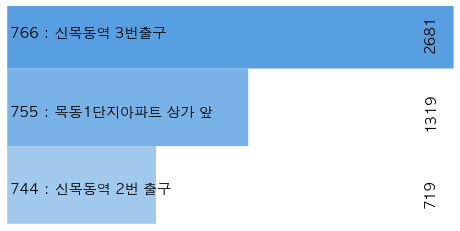

In [245]:
# 반납 : filtered_data_end(=val 1), 대여 : filtered_data_start(=val 2)
def frequent_station(filtered_data,val) :
    data = filtered_data[val].groupby(f'st_id{val}').size().sort_values(ascending=False)[:3]
    data_index = data.index
    labels = [ bike_info.query('value == @i')['label'].iloc[0] for i in data_index]
    data_numpy = data.to_numpy()
    height = list(map(lambda x : round(((x-data_numpy.min())/(data_numpy.max()-data_numpy.min()))+0.5,2), data_numpy ))

    bars = []
    for num, w in enumerate(height[::-1]):
        ist = [0, num, 1, w]  # x,y,h,w
        bars.append(ist)
    print(bars)
    # 날짜
    days = ["월", "화", "수", "목", "금", "토", "일"]

    # plot
    fig, ax = plt.subplots(figsize=(8, 4))

    # bar = rect
    for num, (bar, label) in enumerate(zip(bars, labels)):
        x = bar[0]
        y = bar[1]
        h = bar[2]
        w = bar[3]
        color = ["#A1C9EE", "#79B2E7", "#579FE1"]  # full color, font-color
        bbox = patches.FancyBboxPatch(
            (x, y),
            w,
            h,
            boxstyle="round,pad=-0.0001,rounding_size=0",
            ec="none",
            fc=color[num],
            mutation_aspect=0.5,
            # alpha=1
        )
        ax.add_patch(bbox)

        # # 요일 넣기(padding고려해서 num으로 조정)
        plt.text(
            0.01, y + 0.4, f"{label[:20]}", fontdict={"fontsize": 14, "color": "black"}
        )

        # # 개수 넣기
        # len(data)-1-num으로 한 이유는 역순으로 뽑아야 하기때문
        plt.text(
            1.4,
            y + 0.25,
            data.iloc[len(data) - 1 - num],
            rotation=90,
            fontdict={"fontsize": 14, "color": "black"},
        )


    plt.xlim(0, 1.5)  # 넓이가 0.8이라서 그럼
    plt.ylim(0, 2.8)
    plt.axis("off")
    # plt.close()

frequent_station(test_data,1)


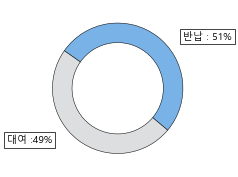

In [38]:
def total_rent(filtered_data) :
    fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

    # 데이터 정제
    a = len(filtered_data[1])
    b = len(filtered_data[2])
    percent = int(a / (a + b) * 100)

    # plot에 필요한 변수 설정
    tag = [f"반납 : {percent}%", f"대여 :{100-percent}%"]
    data = [a, b]
    wedge_properties = {"edgecolor": "k", "linewidth": 2}
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(bbox=bbox_props, zorder=0, va="center")

    # pie plot
    wedges, texts = ax.pie(
        data,
        wedgeprops=dict(width=0.3, edgecolor="k", linewidth=0.5),
        startangle=-40,
        colors=["#79B2E7", "#DCDEDF"],
    )

    # annotation 설정
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1) / 2.0 + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        # kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(
            tag[i],
            xy=(x, y),
            xytext=(1 * np.sign(x), 1 * y),
            horizontalalignment=horizontalalignment,
            **kw,
        )
        ax.text(-0.4, 0.05, "대여소 이용", fontdict={"color": "white"})
        ax.text(-0.3, -0.15, f"{a+b}건", fontdict={"color": "white"})

    # ax.set_title("Matplotlib bakery: A donut")

    # plt.close()

total_rent(raw_data)